In [14]:
import numpy as np
import random
from scipy.optimize import minimize, linear_sum_assignment
import itertools
import matplotlib.pyplot as plt

## Player dictionary
First, preferences - score out of 10 for which positions are preferred.
**TODO: Should I enforce that scores sum to 10?**

In [79]:
# new preference positions

all_players = dict()

# preferred positions
all_players['jazzie'] = [('D',5), ('C', 3), ('W',2), ('F',1)]
all_players['helen'] = [('D', 5), ('C',2), ('W',3.5), ('F',1)]
all_players['christine'] = [('D',0), ('C',1), ('W',4), ('F',5)]
all_players['sian'] = [('D',4), ('C',0), ('W',4), ('F',1)]
all_players['vicky'] = [('D',0), ('C',5), ('W',2.5), ('F',4)]
all_players['keah'] = [('D',1), ('C',5), ('W',3.5), ('F',2)]
all_players['shafa'] = [('D',3), ('C',3), ('W',3.5), ('F',5)]
all_players['olivia'] = [('D',5), ('C',4), ('W',1.5), ('F',0)]
all_players['mychelle'] = [('D',1), ('C',5), ('W',4), ('F',4)]
all_players['jaz'] = [('D',2), ('C',1), ('W',4.5), ('F',3)]

player_costs = dict()

for player in all_players.keys():
    prefs = all_players[player]

    weights = []
    sum_weights = sum(w for pos, w in prefs)
    for x in prefs:
        weight = 1-(x[1]/sum_weights) if x[1]!=0 else 1.0
        weights.append((x[0], weight))
        
    player_costs[player] = weights
    
print(player_costs)

{'jazzie': [('D', 0.5454545454545454), ('C', 0.7272727272727273), ('W', 0.8181818181818181), ('F', 0.9090909090909091)], 'helen': [('D', 0.5652173913043479), ('C', 0.8260869565217391), ('W', 0.6956521739130435), ('F', 0.9130434782608696)], 'christine': [('D', 1.0), ('C', 0.9), ('W', 0.6), ('F', 0.5)], 'sian': [('D', 0.5555555555555556), ('C', 1.0), ('W', 0.5555555555555556), ('F', 0.8888888888888888)], 'vicky': [('D', 1.0), ('C', 0.5652173913043479), ('W', 0.782608695652174), ('F', 0.6521739130434783)], 'keah': [('D', 0.9130434782608696), ('C', 0.5652173913043479), ('W', 0.6956521739130435), ('F', 0.8260869565217391)], 'shafa': [('D', 0.7931034482758621), ('C', 0.7931034482758621), ('W', 0.7586206896551724), ('F', 0.6551724137931034)], 'olivia': [('D', 0.5238095238095238), ('C', 0.6190476190476191), ('W', 0.8571428571428572), ('F', 1.0)], 'mychelle': [('D', 0.9285714285714286), ('C', 0.6428571428571428), ('W', 0.7142857142857143), ('F', 0.7142857142857143)], 'jaz': [('D', 0.80952380952

In [64]:
# array format: [defender, central, winger, forward]

all_players = dict()

# preferred positions
all_players['jazzie'] = [('D',10), ('C',0), ('W',0), ('F',0)]
all_players['caroline'] = [('D',10), ('C',0), ('W',0), ('F',0)]
all_players['helen'] = [('D', 8), ('C',0), ('W',2), ('F',0)]
all_players['christine'] = [('D',0), ('C',0), ('W',2), ('F',8)]
all_players['sian'] = [('D',5), ('C',0), ('W',5), ('F',0)]
all_players['vicky'] = [('D',0), ('C',6), ('W',3), ('F',1)]
all_players['keah'] = [('D',0), ('C',3), ('W',5), ('F',2)]
all_players['shafa'] = [('D',4), ('C',0), ('W',3), ('F',7)]
all_players['olivia'] = [('D',10), ('C',0), ('W',0), ('F',0)]
all_players['mychelle'] = [('D',0), ('C',6), ('W',0), ('F',3)]
all_players['jaz'] = [('D',0), ('C',2), ('W',8), ('F',0)]

#convert preferences to costs
player_costs = dict()

for player in all_players.keys():
    prefs = all_players[player]

    weights = []
    for x in prefs:
        weight = 1-(x[1]/10) if x[1]!=0 else 1.0
        weights.append((x[0], weight))
        
    player_costs[player] = weights

## Helper functions

In [80]:
def get_this_week_player_costs(this_week, player_costs=player_costs):
    this_week_player_costs = dict()
    for player in this_week:
        this_week_player_costs[player] = player_costs[player]
    return this_week_player_costs

def dict_to_cost_matrix(player_costs, formation):
    cost_matrix = []
    for player in player_costs:
        cost_list = []
        for position in formation:
            for x in player_costs[player]:
                if x[0]==position:
                    cost_list.append(x[1])
        cost_matrix.append(cost_list)
    
    return np.array(cost_matrix)

def append_subs_to_cost_matrix(cost_matrix, subs_weights):
    n_subs = len(cost_matrix) - 6
    cost_matrix_with_subs = []
    for i in range(len(cost_matrix)):
        cost_list = list(cost_matrix[i])
        for j in range(n_subs):
            cost_list.append(subs_weights[i])
        cost_matrix_with_subs.append(cost_list)
    return np.array(cost_matrix_with_subs)

def alter_subs_weights(cost_matrix, subs_weights):
    n_subs = len(cost_matrix) - 6
    cost_matrix_with_subs = []
    for i in range(len(cost_matrix)):
        cost_list = list(cost_matrix[i])
        for j in range(n_subs):
            cost_list[-(j+1)] = subs_weights[i] 
        cost_matrix_with_subs.append(cost_list)
    return np.array(cost_matrix_with_subs)

def convert_lsa_output_to_formation(cm, row_ind, col_ind, this_week, formation_with_subs):
    formation_dict = {'D':[], 'C':[], 'W':[], 'F':[], 'S':[]}
    for i in range(len(col_ind)):
        position = formation_with_subs[col_ind[i]]
        player = this_week[i]
        formation_dict[position].append(player)
    formation_dict['cost'] = cm[row_ind, col_ind].sum()
    return formation_dict

def convert_formation_to_list(formation_dict):
    out_list = [['etsuko']]
    out_list.append(formation_dict['D'])
    out_list.append(formation_dict['C'])
    out_list.append(formation_dict['W'])
    out_list.append(formation_dict['F'])
    out_list.append(formation_dict['S'])
    return list(np.concatenate(out_list).flat)

## Get players this week
**TODO: What happens without Etsuko?**

In [82]:
this_week = []
while True:
    entry  = input('Add player (type x to finish): ')
    if entry == 'x':
        break
    while entry not in player_costs.keys():
        entry = input('Previous entry was invalid, please try again... ')
        
    this_week.append(entry)

n_players_this_week = len(this_week)
    
print(f"This week's squad: {this_week} ({n_players_this_week})")

Add player (type x to finish): olivia
Add player (type x to finish): kead
Previous entry was invalid, please try again... keah
Add player (type x to finish): sian
Add player (type x to finish): vicky
Add player (type x to finish): jaz
Add player (type x to finish): jazzie
Add player (type x to finish): christine
Add player (type x to finish): shafa
Add player (type x to finish): helen
Add player (type x to finish): x
This week's squad: ['olivia', 'keah', 'sian', 'vicky', 'jaz', 'jazzie', 'christine', 'shafa', 'helen'] (9)


## Set up formation and get costs

In [83]:
formation = ['D', 'D', 'C', 'W', 'W', 'F']
formation_with_subs = formation.copy()
for i in range(n_players_this_week-6):
    formation_with_subs.append('S')

random.shuffle(this_week)
this_week_player_costs = get_this_week_player_costs(this_week)
cm_no_subs = dict_to_cost_matrix(this_week_player_costs, formation)

## Set substitute weight

In [84]:
sub_weight = 5.0 # cost of previously-subbed player getting subbed again

n_repeats = 0
if n_players_this_week == 7:
    n_repeats = 7
elif n_players_this_week == 8:
    n_repeats = 4
elif n_players_this_week == 9:
    n_repeats = 3

## Straight-up linear sum assignment

In [85]:
initial_subs_weights = np.zeros(n_players_this_week)
cm = append_subs_to_cost_matrix(cm_no_subs, initial_subs_weights)
    
subs_weights = initial_subs_weights.copy()
for i in range(n_repeats):
    row_ind, col_ind = linear_sum_assignment(cm)
    print(convert_lsa_output_to_formation(cm, row_ind, col_ind, this_week, formation_with_subs))
    
    for i in range(len(row_ind)):
        if formation_with_subs[col_ind[i]]=='S':
            subs_weights[i] += sub_weight
    cm = alter_subs_weights(cm, subs_weights)

{'D': ['jazzie', 'olivia'], 'C': ['vicky'], 'W': ['jaz', 'sian'], 'F': ['christine'], 'S': ['shafa', 'helen', 'keah'], 'cost': 3.261465587552544}
{'D': ['olivia', 'helen'], 'C': ['keah'], 'W': ['jaz', 'sian'], 'F': ['shafa'], 'S': ['christine', 'jazzie', 'vicky'], 'cost': 3.4364008471954497}
{'D': ['jazzie', 'helen'], 'C': ['vicky'], 'W': ['christine', 'keah'], 'F': ['shafa'], 'S': ['jaz', 'sian', 'olivia'], 'cost': 3.626713915769388}


In [86]:
def objective_function(x, cm_no_subs, n_repeats):
    
    vals = []
    
    cm = append_subs_to_cost_matrix(cm_no_subs, x)
    subs_weights = x.copy()
    
    for i in range(n_repeats):
        row_ind, col_ind = linear_sum_assignment(cm)
        formation_dict = convert_lsa_output_to_formation(cm, row_ind, col_ind, this_week, formation_with_subs)
        vals.append(formation_dict['cost'])

        for i in range(len(row_ind)):
            if formation_with_subs[col_ind[i]]=='S':
                subs_weights[i] += 1.0
        cm = alter_subs_weights(cm, subs_weights)
    
    val = np.var(vals)
    #print(x, val)
    
    return val

In [87]:
bound = (0, 1)
bounds = []
for i in range(n_players_this_week):
    bounds.append(bound)
    
res = minimize(objective_function, x0=np.zeros(n_players_this_week), args=(cm_no_subs, n_repeats), bounds=bounds, method='SLSQP', options={'eps':0.1})
print(res)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.007631728630115501
       x: [ 1.585e-01  2.766e-17  5.502e-17  0.000e+00  2.398e-22
            2.422e-23  1.428e-02  3.472e-17  1.428e-02]
     nit: 3
     jac: [ 6.252e-02  1.041e-01  5.652e-02  1.041e-01  6.788e-02
            1.041e-01 -1.101e-02  3.436e-02 -1.101e-02]
    nfev: 41
    njev: 3


In [88]:
initial_subs_weights = res.x
cm = append_subs_to_cost_matrix(cm_no_subs, initial_subs_weights)
    
subs_weights = initial_subs_weights.copy()

for_display = []
for i in range(n_repeats):
    row_ind, col_ind = linear_sum_assignment(cm)
    formation_dict = convert_lsa_output_to_formation(cm, row_ind, col_ind, this_week, formation_with_subs)
    print(formation_dict)
    for_display.append(convert_formation_to_list(formation_dict))
    
    for i in range(len(row_ind)):
        if formation_with_subs[col_ind[i]]=='S':
            subs_weights[i] += sub_weight
    cm = alter_subs_weights(cm, subs_weights)

{'D': ['jazzie', 'olivia'], 'C': ['keah'], 'W': ['jaz', 'sian'], 'F': ['shafa'], 'S': ['christine', 'vicky', 'helen'], 'cost': 3.430917285675525}
{'D': ['olivia', 'helen'], 'C': ['vicky'], 'W': ['jaz', 'sian'], 'F': ['christine'], 'S': ['shafa', 'jazzie', 'keah'], 'cost': 3.4540456965601867}
{'D': ['jazzie', 'helen'], 'C': ['vicky'], 'W': ['christine', 'keah'], 'F': ['shafa'], 'S': ['jaz', 'sian', 'olivia'], 'cost': 3.626713915769388}


In [89]:
def plot_formation(formation, t_start, t_stop):
    # format for formation should be: GK, LB, RB, C, LW, RW, CF, S, S, S
    make_pitch()
    
    positions_x = [2.5, 1.5, 3.5, 2.5, 0.5, 4.5, 2.5, 6.5, 6.5, 6.5]
    positions_y = [4, 2.8, 2.8, 1.6, 1, 1, 0, 3, 2, 1]
    
    for i in range(len(formation)):
        plt.annotate(formation[i], (positions_x[i], positions_y[i]+0.25), color='white', fontsize=14, ha='center')
    
    plt.plot(positions_x, positions_y, 'o', ms=10, markerfacecolor='red', markeredgecolor='white')
    
    plt.annotate(f'{t_start} - {t_stop} mins', (3.5, 5), color='white', fontsize=14, ha='center' )
    
def make_pitch():
    plt.figure(figsize=[6,6])
    plt.xlim([-1, 8])
    plt.ylim([-1, 5.5])
    plt.hlines([4.5, -0.5], -0.5, 5.5, color='white' )
    plt.hlines(3.5, 1.5, 3.5, color='white')
    plt.vlines([-0.5, 5.5], -0.5, 4.5, color='white')
    plt.vlines([1.5, 3.5], 3.5, 4.5, color='white')

    plt.plot([2.5], [-0.5], 'o', ms=5, color='w')
    
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.set_facecolor('green')
    
    return ax

def make_pitches(n_repeats):
    fig, axs = plt.subplots(1, n_repeats, figsize = (6*n_repeats, 6))

    for ax in axs:
        ax.set_xlim([-1, 8])
        ax.set_ylim([-1, 5.5])
        ax.hlines([-0.5, 4.5], -0.5, 5.5, color='white')
        ax.hlines(3.5, 1.5, 3.5, color='white')
        ax.vlines([-0.5, 5.5], -0.5, 4.5, color='white')
        ax.vlines([1.5, 3.5], 3.5, 4.5, color='white')

        ax.plot([2.5], [-0.5], 'o', ms=5, color='w')

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax.set_facecolor('green')
    
    return axs

def plot_formations(list_of_formations, t_start, t_stop):
    
    n_repeats = len(list_of_formations)
    interval = int((t_stop-t_start)/n_repeats)
    axs = make_pitches(n_repeats)
    
    positions_x = [2.5, 1.5, 3.5, 2.5, 0.5, 4.5, 2.5, 6.5, 6.5, 6.5]
    positions_y = [4, 2.8, 2.8, 1.6, 1, 1, 0, 3, 2, 1]
    
    for n in range(n_repeats):
        formation = list_of_formations[n]
        plt.axes(axs[n])
    
        for i in range(len(formation)):
            plt.annotate(formation[i], (positions_x[i], positions_y[i]+0.25), color='white', fontsize=14, ha='center')

        plt.plot(positions_x, positions_y, 'o', ms=10, markerfacecolor='red', markeredgecolor='white')

        plt.annotate(f'{n*interval} - {(n+1)*interval} mins', (3.5, 5), color='white', fontsize=14, ha='center')
        
    plt.show()

In [90]:
print(for_display)

[['etsuko', 'jazzie', 'olivia', 'keah', 'jaz', 'sian', 'shafa', 'christine', 'vicky', 'helen'], ['etsuko', 'olivia', 'helen', 'vicky', 'jaz', 'sian', 'christine', 'shafa', 'jazzie', 'keah'], ['etsuko', 'jazzie', 'helen', 'vicky', 'christine', 'keah', 'shafa', 'jaz', 'sian', 'olivia']]


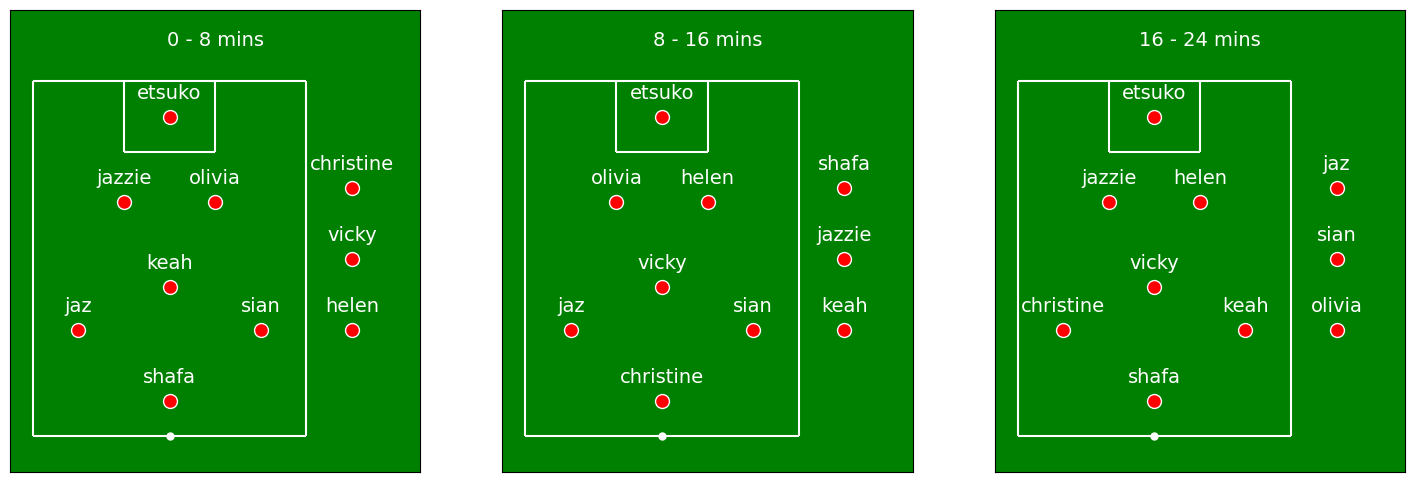

In [91]:
plot_formations(for_display, 0, 25)

In [77]:
for_display_modified = []
for_display_modified.append(for_display[2])
for_display_modified.append(for_display[1])
for_display_modified.append(for_display[0])

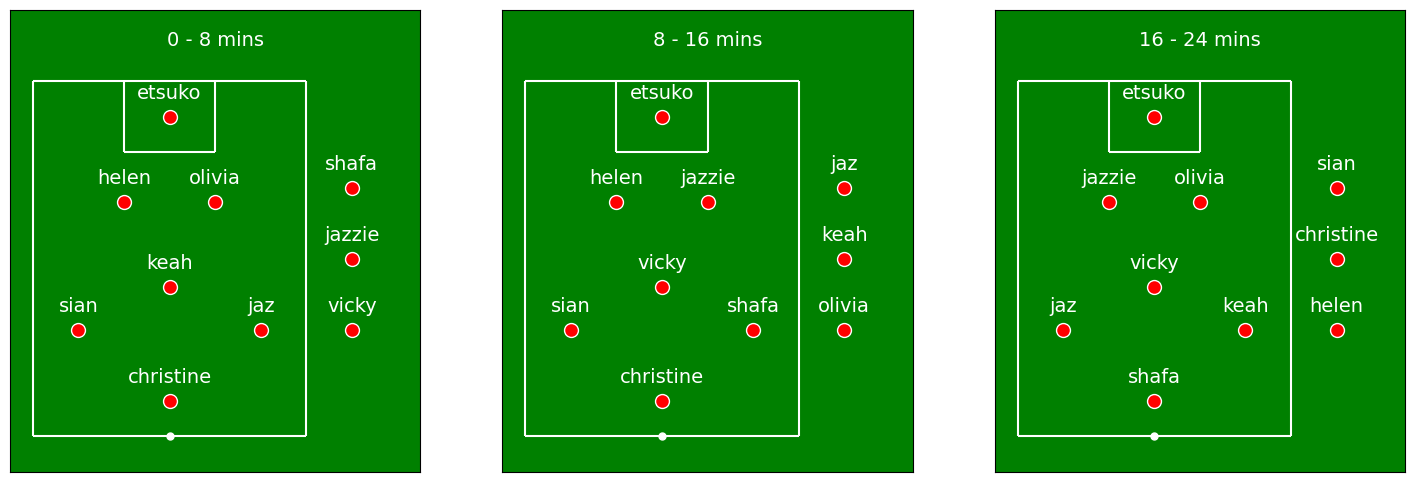

In [78]:
plot_formations(for_display_modified, 0, 25)